In [1]:
import numpy as np
import glob
import collections
import warnings
warnings.filterwarnings('ignore')
import random
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import rc
import pickle 

In [2]:
experi2 = {}
path = glob.glob('./two_step_alg_result/*[0-9].txt')
for p in path: 
    p_ = p.replace('N','-')
    p_ = p_.replace('P','-')
    p_ = p_.replace('trial','-')
    p_ = p_.split('-')
    N, P, seed = int(p_[1]), int(p_[2]), int(p_[3][0])
    
    if N not in experi2:
        experi2[N] = {}
        
    if P not in experi2[N]:
        experi2[N][P] = np.ones((20, ), dtype = int) * np.nan
    try:
        with open(p, 'r') as f:
            reader = f.read()
            experi2[N][P][seed] = (int(reader.split(',')[3]) == 0)
    except:
        continue
for N in experi2:
    experi2[N] = collections.OrderedDict(sorted(experi2[(N)].items()))  
    for P in experi2[N]:
        experi2[N][P] = experi2[N][P][~np.isnan(experi2[N][P])]
experi2 =  collections.OrderedDict(sorted(experi2.items()))  

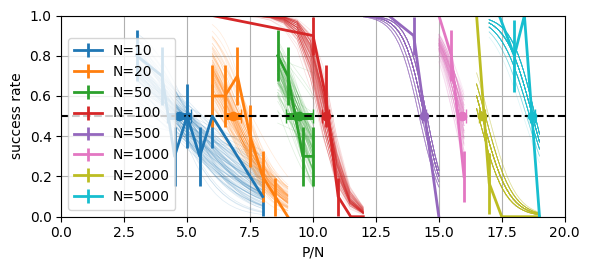

In [3]:
plt.figure(figsize = (6, 2.8))
 
c = ['tab:blue','tab:orange', 'tab:green', 'tab:red',\
     'tab:purple', 'tab:brown','tab:pink', 'tab:olive', 'tab:cyan']

arrayN = np.array([10, 20, 50, 100,500, 800,1000, 2000, 5000])
capacityms = []
for count, N in enumerate(experi2): 
    
    sample = 100
    psedoC = []
    for i in range(sample):
        psedoX = []
        psedoY = []
        
        for P in experi2[N]:
            psedoX += ([P/N] * len(experi2[N][P]))
            psedoY += random.choices(experi2[N][P], k=len(experi2[N][P]))
        if min(psedoY) == max(psedoY):
            continue
        clf = LogisticRegression().fit(np.array(psedoX).reshape(-1, 1), np.array(psedoY))
        newX = np.linspace(min(experi2[N].keys())/N, max(experi2[N].keys())/N,20)
        if  np.abs(-clf.intercept_[0] / clf.coef_[0][0] ) > 20:
            continue
        psedoC.append( -clf.intercept_[0] / clf.coef_[0][0])
        
        
        probs = clf.predict_proba(newX.reshape(-1, 1))
        
        plt.plot(newX, probs[:,1], alpha = .15, linewidth = .5, \
                color = c[np.where(arrayN == N)[0][0]])
        
    capacityms.append( [N, np.array(psedoC).mean(), np.array(psedoC).std()])
    
    plt.errorbar(np.array(list(experi2[N].keys()))/N, \
            [np.mean(np.array(experi2[N][P])) for P in experi2[N]],\
            yerr = [np.std(np.array(experi2[N][P]))/np.sqrt(len(experi2[N][P])) for P in experi2[N]],\
            label = 'N='+str(N),linewidth = 2,\
            color = c[np.where(arrayN == N)[0][0]] )

    plt.errorbar([np.array(psedoC).mean()], [0.5], xerr =np.array(psedoC).std() ,\
                fmt='o', linewidth=5, capsize = 5,\
                color = c[np.where(arrayN == N)[0][0]])

capacityms = np.array(capacityms)
plt.legend()
plt.xlim([0,20])
plt.ylim([0,1])
plt.plot([0,20],[.5,.5],'k--')   
plt.grid()
plt.xlabel('P/N')
plt.ylabel('success rate')

plt.tight_layout()

plt.savefig('capacityms.pdf')
plt.show()

In [4]:
with open('capacity_restricted_model.pkl', 'rb') as f:
    capacity = pickle.load(f)

## Fig 3a

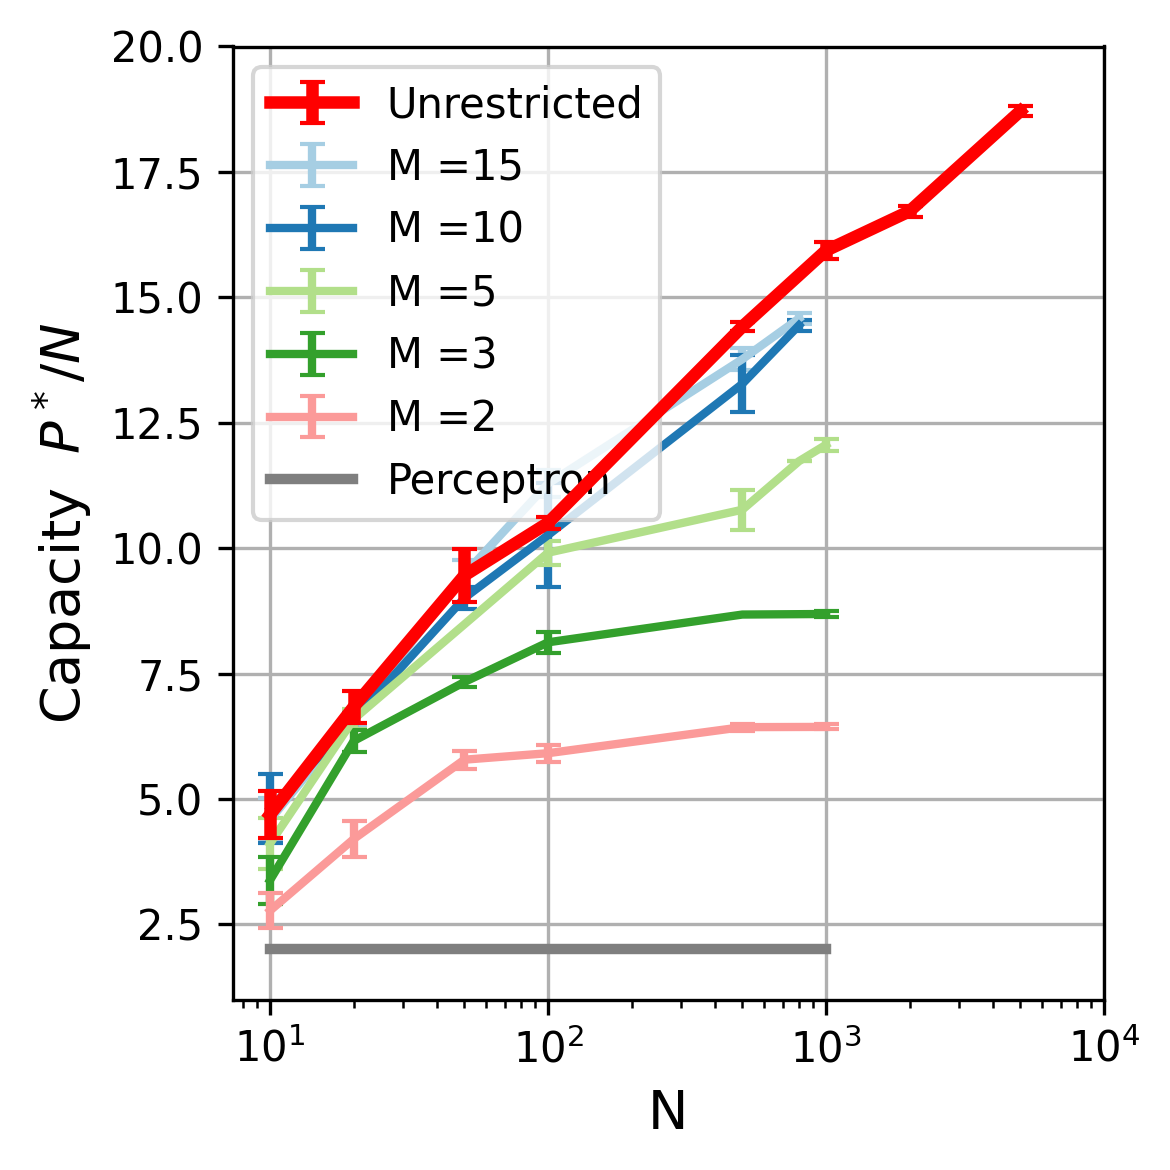

In [5]:
fig, ax = plt.subplots(figsize = (4.,4.), dpi=300)

# Get the 'Pastel1' colormap
cmap = plt.cm.get_cmap('Paired')

# Define the number of discrete colors you want
num_colors = 5

# Get the discrete colors from the colormap
color = [cmap(i) for i in range(num_colors)]

# color =  ["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]
plt.errorbar(capacityms[:, 0], capacityms[:, 1], yerr =capacityms[:, 2], \
                capsize = 3, color = 'red' , label = 'Unrestricted', linewidth = 3, zorder = 10)
for i, M in [(0,15), (1,10), (2,5), (3,3), (4,2)]:
    if M == 15:
        plt.errorbar(capacity[M][:-1, 0], capacity[M][:-1, 2], yerr =capacity[M][:-1, 3], \
                capsize = 3, color =color[i] , label = 'M ='+str(M), linewidth = 2 )
        continue
    if M == 10:
        plt.errorbar(capacity[M][:-1, 0], capacity[M][:-1, 2], yerr =capacity[M][:-1, 3], \
                capsize = 3, color =color[i] , label = 'M ='+str(M), linewidth = 2 )
        continue
    x, y, yerr = capacity[M][:, 0], capacity[M][:, 2], capacity[M][:, 3]

    plt.errorbar(x[~np.isnan(y)], y[~np.isnan(y)], yerr =yerr[~np.isnan(y)], \
                capsize = 3, color =color[i] , label = 'M ='+str(M), linewidth = 2  )

# plt.legend( prop={'size':10},loc='upper left') 
plt.plot(np.linspace(10, 1e3,5), np.ones((5,))*2, 'tab:grey', linewidth = 2.5, label = 'Perceptron')

handles, labels = ax.get_legend_handles_labels()
# put the perceptron label at the last
handles = handles[1:] + [handles[0]]
labels = labels[1:] + [labels[0]]
plt.legend(handles,  labels, prop={'size':10}, loc='upper left')

plt.xscale('log')  
plt.grid()

plt.xlabel('N', fontsize =13)
plt.ylabel('Capacity '+r' $P^*/N $', fontsize =13) 
plt.xlim([-15,1e4])
plt.ylim([1,20])

plt.tight_layout()

plt.savefig('capacity_two.pdf')

In [6]:
# effM = {}# effective steps for two-step algorithms
# for N in experi2:
#     # if N != 2000:# or N == 5000:
#     #     continue
#     # if N not in effM:
        
#     #     effM[N] = []
#     for P in experi2[N]:
        
#         seeds = np.where(experi2[N][P] == 1.)[0]
# #         print(seeds)
#         if seeds.size == 0:
#             continue
#         effM[(N,P)] = []
#         if (N, P) in effM and len(effM[(N,P)]) > 0:
#             continue
#         if N < 2000:
#             actv = []
#             for seed in seeds: 
#                 with open('./monsyn4/monsyn4func/N'+str(N)+'P'+str(P)+'trial'+str(seed)+'func.txt', 'r') as f:
#                     line = f.readline()
#                     while line:
#                         line = line.replace(' \n','')
#                         actv.append([float(a) for a in line.split(' ')])
#                         line = f.readline()
            
#             actv = np.array(actv)
#         if N >= 2000:
#             ampli = np.load('./monsyn4/monsyn4ampli/N'+str(N)+'P'+str(P)+'trial'+str(seed)+'ampli.npy')
#             # ampli = np.zeros((N, P-1))
#             # for i in range(N):
#             #     ampli[i,:P//2-1] = np.diff(actv[i,:P//2])
#             #     ampli[i,P//2-1:] = np.diff(actv[i,P//2:])
#         else:
#             ampli = np.diff(actv, axis = 1)
        
#         step = (ampli > ampli.max() * 0.01).sum(axis = 1)

#         effM[(N,P)].append(step)

        
#         print([N,P])
#         with open('effective_synapse.pkl', 'wb') as file:
#             pickle.dump(effM, file)

In [10]:
N = 1000
P = 16000
seed = 0
actv = []
for i in range(1):

    with open('./monsyn4/N'+str(N)+'P'+str(P)+'trial'+str(i)+'func.txt', 'r') as f:
        line = f.readline()
        while line:
            line = line.replace(' \n','')
            actv.append([float(a) for a in line.split(' ')])
            line = f.readline()
        
actv = np.array(actv) 

## Fig 3b

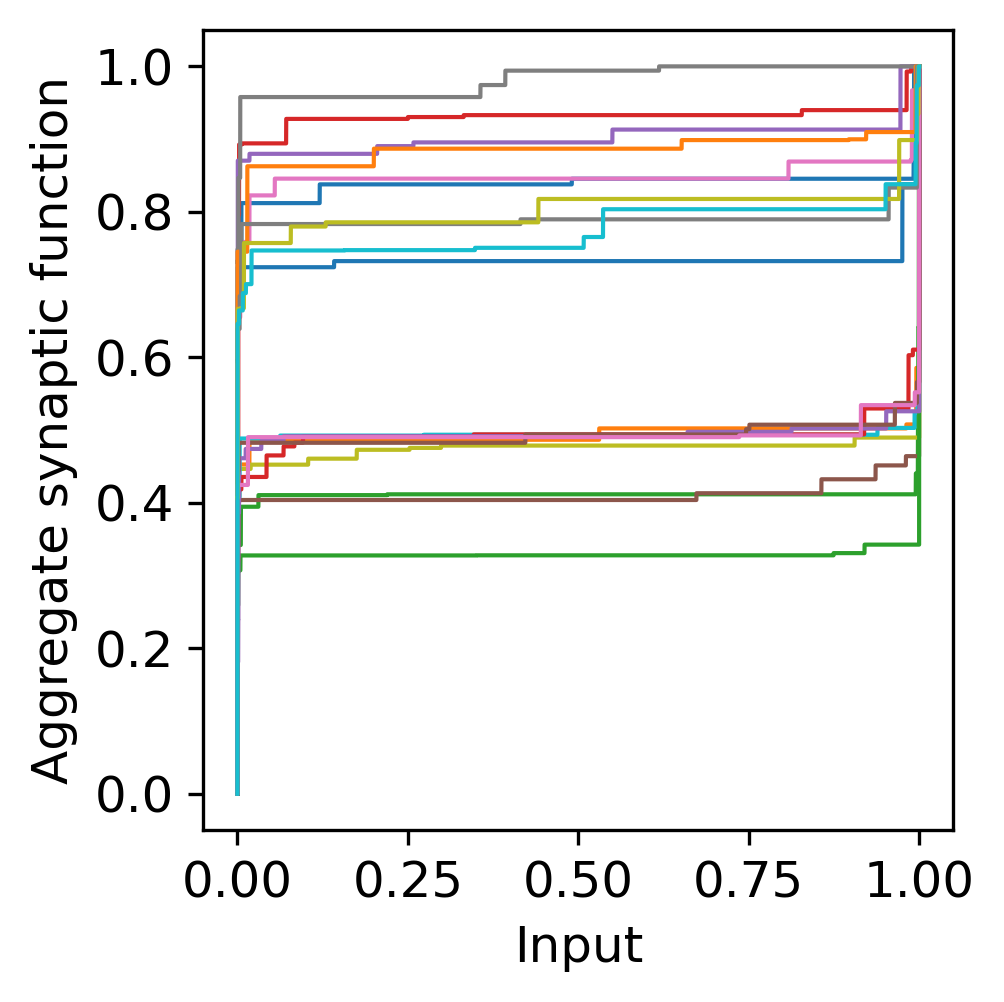

In [ ]:
nShow = 20
plt.figure(figsize = (3.5, 3.5),dpi = 300)
plt.rcParams.update({'font.size': 12})
# plt.plot(np.linspace(0, 1, P),actv[:nShow,:].T,alpha = 0.75)
plt.plot(np.linspace(0, 1, P),(actv[:nShow,:]/np.max(actv[:nShow,:], axis = 1, keepdims = True)).T, alpha = 1, linewidth = 1)
plt.xlabel('Input')

plt.ylabel('Aggregate synaptic function')
# plt.title('aggregate synaptic function')
plt.tight_layout()
plt.savefig('activation' + 'monsyn.pdf')
plt.show()


## Fig 3d - 3f

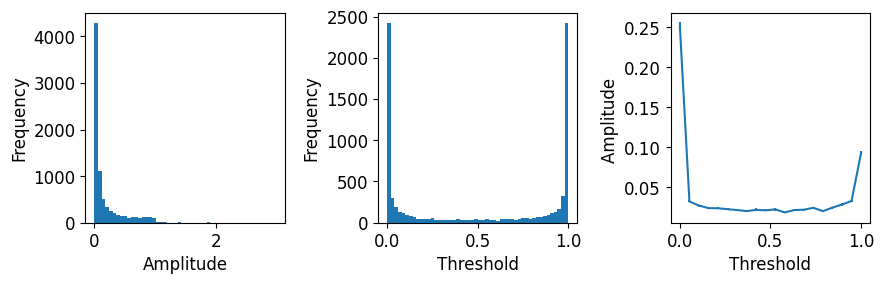

In [ ]:

amp = np.diff(actv, axis = 1)
nBin = 20
ampli = []
N, P = amp.shape
step = int(P/nBin)
for i in range(nBin):
    start = i * step
    end = (i + 1) * step
    tmp = amp[:, start:end]
    ampli.append(tmp[tmp > 0.01])
thres = [np.where(amp[i,:] > 0)[0]/amp.shape[1] for i in range(amp.shape[0])]
plt.figure(figsize = (9,3.))
plt.subplot(1,3,1)
plt.hist(amp[amp > 0], bins = 50)
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
# plt.title('amplitude histogram')
plt.subplot(1,3,2)
plt.hist(np.concatenate(thres, axis = 0), bins = 50)
plt.xlabel('Threshold')
plt.ylabel('Frequency')
# plt.title('threshold histogram')
plt.subplot(1,3,3)
plt.errorbar(np.linspace(0, 1, nBin), [amp.mean() for amp in ampli], \
             yerr = [amp.std()/np.sqrt(len(amp)) for amp in ampli])
plt.xlabel('Threshold')
plt.ylabel('Amplitude ')
# plt.title('amplitude vs threshold')
plt.tight_layout()
plt.savefig('ampli_thres2.pdf')
plt.show()